
> **If you like the notebook, plsease don't forget to upvot it. It is the only source of motivation to create such notebooks when people appreciate the hard work done.**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#  Guide to Tabular Deep Learning with PyTabKit

This notebook uses **PyTabKit**, a modern library that makes state-of-the-art Deep Learning models for tabular data as easy to use as Scikit-Learn. Below is a breakdown of the key concepts and models used.

---

**What is PyTabKit?**
**PyTabKit** is a comprehensive toolkit for tabular machine learning. While Gradient Boosted Trees (like XGBoost, CatBoost) have historically dominated tabular data, PyTabKit bridges the gap for Deep Learning by providing:
* **Scikit-Learn Interfaces:** You can use `.fit()` and `.predict()` just like you do with Random Forests.
* **Tuned Defaults (TD):** Deep Learning usually requires painful hyperparameter tuning. PyTabKit comes with "Tuned Defaults" (TD) that perform competitively out-of-the-box without needing manual tweaking.
* **Best Practices Baked-In:** It automatically handles preprocessing (scaling, categorical encoding) and device management (CPU/GPU) internally.

---

**Model: RealMLP (Realistic MLP)**
**RealMLP** is a modern, optimized version of the classic Multilayer Perceptron (Neural Network).

**Why "Real"?**
Standard MLPs often perform poorly on tabular data compared to Trees. **RealMLP** fixes this by applying a "bag of tricks" derived from extensive research benchmarks:
1.  **Specialized Preprocessing:** Uses robust scaling and smooth clipping to handle outliers better than standard MLPs.
2.  **Embeddings:** It doesn't just treat categories as numbers; it learns dense vector embeddings for them (similar to how LLMs treat words).
3.  **Architecture:** It uses specific activation functions (often SELU or Mish) and layer structures that are mathematically optimized for tabular data distributions.

**When to use:** This is your **fast, strong baseline**. It is generally much faster to train than Transformers and often competitive with XGBoost/CatBoost.

> **Install PytabKit for Offline Running But before running this Go to Add input and then Select Dataset- "pytabkit-1-5-0-offline"** 

In [2]:
# The --no-index flag tells pip NOT to try connecting to the internet
!pip install pytabkit --no-index --find-links=file:////kaggle/input/pytabkit-1-5-0-offline/

Looking in links: file:////kaggle/input/pytabkit-1-5-0-offline/
Processing //kaggle/input/pytabkit-1-5-0-offline/pytabkit-1.5.0-py3-none-any.whl


In [3]:
pd.set_option('display.max_columns', None)

In [4]:
import warnings
import os

# 1. Suppress the Scikit-Learn "force_all_finite" FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.deprecation")

# 2. Suppress the PyTorch "non-tuple sequence" UserWarning
warnings.filterwarnings("ignore", message=".*Using a non-tuple sequence for multidimensional indexing is deprecated.*")

# 3. Suppress PyTorch Lightning "CUDA_VISIBLE_DEVICES" info (optional)
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# Load The Data

In [5]:
df_train=pd.read_csv("/kaggle/input/playground-series-s6e2/train.csv")
df_test=pd.read_csv("/kaggle/input/playground-series-s6e2/test.csv")
sample_submission=pd.read_csv("/kaggle/input/playground-series-s6e2/sample_submission.csv")

In [6]:
df_train.head(5)

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [7]:
df_test.head(5)

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,630000,58,1,3,120,288,0,2,145,1,0.8,2,3,3
1,630001,55,0,2,120,209,0,0,172,0,0.0,1,0,3
2,630002,54,1,4,120,268,0,0,150,1,0.0,2,3,7
3,630003,44,0,3,112,177,0,0,168,0,0.9,1,0,3
4,630004,43,1,1,138,267,0,0,163,0,1.8,2,0,7


Drop the id column from th train and test data

In [8]:
df_train.drop(columns=["id"], axis=1, inplace=True)
df_test.drop(columns=["id"], axis=1, inplace=True)

# EDA Pipeline for Train and Test Data

In [9]:
target_variable="Heart Disease"

In [10]:
# Convert target to binary
df_train[target_variable] = df_train[target_variable].map({"Absence": 0, "Presence": 1})

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
def eda_pipeline(df_train, df_test):
    
    # Display first few rows
    print("\n--- First few rows of train data ---")
    display(df_train.head())
    
    print("\n--- First few rows of test data ---")
    display(df_test.head())
    
    # Dataset info
    print("\n--- Train Data Info ---")
    print(df_train.info())
    
    print("\n--- Test Data Info ---")
    print(df_test.info())
    
    # Missing values
    print("\n--- Missing Values in Train Data ---")
    print(df_train.isnull().sum())
    
    print("\n--- Missing Values in Test Data ---")
    print(df_test.isnull().sum())
    
    print("\n--- Percentage of Missing Values in Train Data ---")
    print((df_train.isnull().sum() / len(df_train)) * 100)
    
    print("\n--- Percentage of Missing Values in Test Data ---")
    print((df_test.isnull().sum() / len(df_test)) * 100)
    
    # Summary statistics
    print("\n--- Train Data Summary Statistics ---")
    print(df_train.describe())
    
    print("\n--- Test Data Summary Statistics ---")
    print(df_test.describe())
    
    # Identify categorical columns
    train_cat_columns = [col for col in df_train.columns if df_train[col].dtype == 'O']
    test_cat_columns = [col for col in df_test.columns if df_test[col].dtype == 'O']
    
    print("\n--- Categorical Columns in Train Data ---")
    print(train_cat_columns)
    
    print("\n--- Unique Values in Categorical Columns (Train) ---")
    print(df_train[train_cat_columns].nunique())
    
    print("\n--- Categorical Columns in Test Data ---")
    print(test_cat_columns)
    
    print("\n--- Unique Values in Categorical Columns (Test) ---")
    print(df_test[test_cat_columns].nunique())
    
    # Identify numerical columns
    train_num_columns = [col for col in df_train.columns if df_train[col].dtype in ['int64', 'float64']]
    test_num_columns = [col for col in df_test.columns if df_test[col].dtype in ['int64', 'float64']]
    
    print("\n--- Numerical Columns in Train Data ---")
    print(train_num_columns)
    
    print("\n--- Numerical Columns in Test Data ---")
    print(test_num_columns)
    
    # Check for duplicate rows
    print("\n--- Duplicate Rows in Train Data ---")
    print(df_train.duplicated().sum())
    
    print("\n--- Duplicate Rows in Test Data ---")
    print(df_test.duplicated().sum())
    
    # Correlation matrix (excluding non-numeric columns)
    print("\n--- Correlation Matrix ---")
    plt.figure(figsize=(12, 6))
    sns.heatmap(df_train[train_num_columns].corr(), annot=True, cmap='coolwarm')
    plt.show()
       
    # Correlation with Target Variable
    print("\n--- Correlation with Target Variable ---")
    target_corr = df_train[train_num_columns].corr()[target_variable].sort_values(ascending=False)
    print(target_corr)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=target_corr.index, y=target_corr.values, palette='coolwarm')
    plt.xticks(rotation=90)
    plt.title(f'Feature Correlation with {target_variable}')
    plt.show()   
    
    # Distribution plots for numerical features
    print("\n--- Distribution of Numerical Features ---")
    df_train[train_num_columns].hist(figsize=(12, 10), bins=30)
    plt.show()
    
    # Box plots for outlier detection
    print("\n--- Box Plots for Outlier Detection ---")
    for col in train_num_columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df_train[col])
        plt.title(f'Box plot of {col}')
        plt.show()
    
    # Value counts for categorical features
    print("\n--- Value Counts for Categorical Columns ---")
    for col in train_cat_columns:
        print(f"\nValue counts for {col}:")
        print(df_train[col].value_counts())


--- First few rows of train data ---


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,1



--- First few rows of test data ---


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,58,1,3,120,288,0,2,145,1,0.8,2,3,3
1,55,0,2,120,209,0,0,172,0,0.0,1,0,3
2,54,1,4,120,268,0,0,150,1,0.0,2,3,7
3,44,0,3,112,177,0,0,168,0,0.9,1,0,3
4,43,1,1,138,267,0,0,163,0,1.8,2,0,7



--- Train Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      630000 non-null  int64  
 1   Sex                      630000 non-null  int64  
 2   Chest pain type          630000 non-null  int64  
 3   BP                       630000 non-null  int64  
 4   Cholesterol              630000 non-null  int64  
 5   FBS over 120             630000 non-null  int64  
 6   EKG results              630000 non-null  int64  
 7   Max HR                   630000 non-null  int64  
 8   Exercise angina          630000 non-null  int64  
 9   ST depression            630000 non-null  float64
 10  Slope of ST              630000 non-null  int64  
 11  Number of vessels fluro  630000 non-null  int64  
 12  Thallium                 630000 non-null  int64  
 13  Heart Disease            630000 no

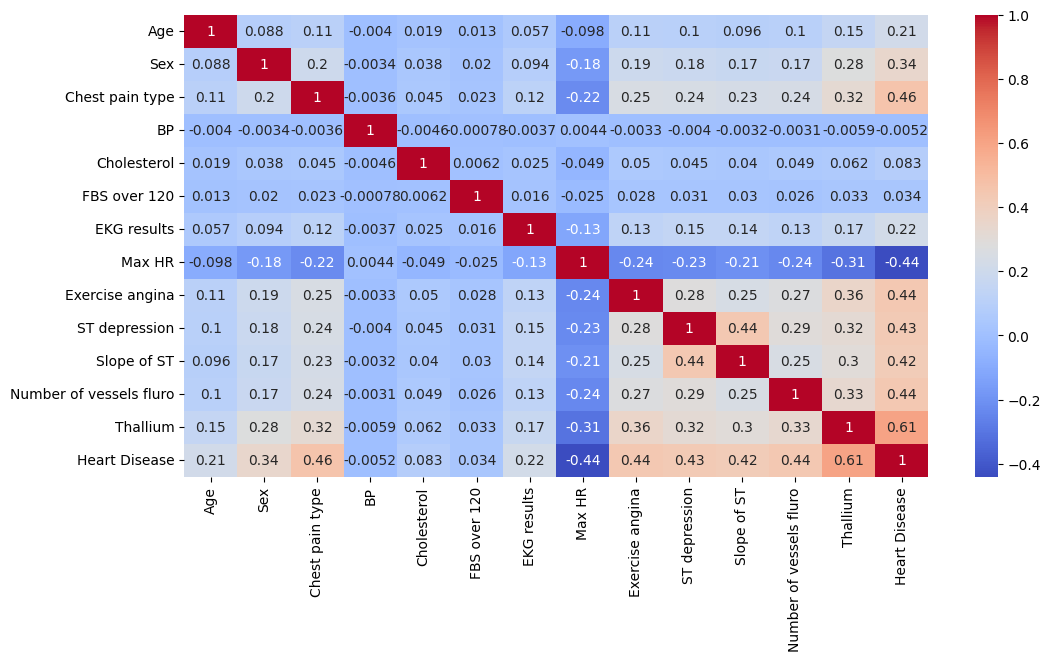


--- Correlation with Target Variable ---
Heart Disease              1.000000
Thallium                   0.605776
Chest pain type            0.460684
Exercise angina            0.441864
Number of vessels fluro    0.438604
ST depression              0.430641
Slope of ST                0.415050
Sex                        0.342446
EKG results                0.218961
Age                        0.212091
Cholesterol                0.082753
FBS over 120               0.033570
BP                        -0.005181
Max HR                    -0.440985
Name: Heart Disease, dtype: float64


/tmp/ipykernel_24/4092408763.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.index, y=target_corr.values, palette='coolwarm')


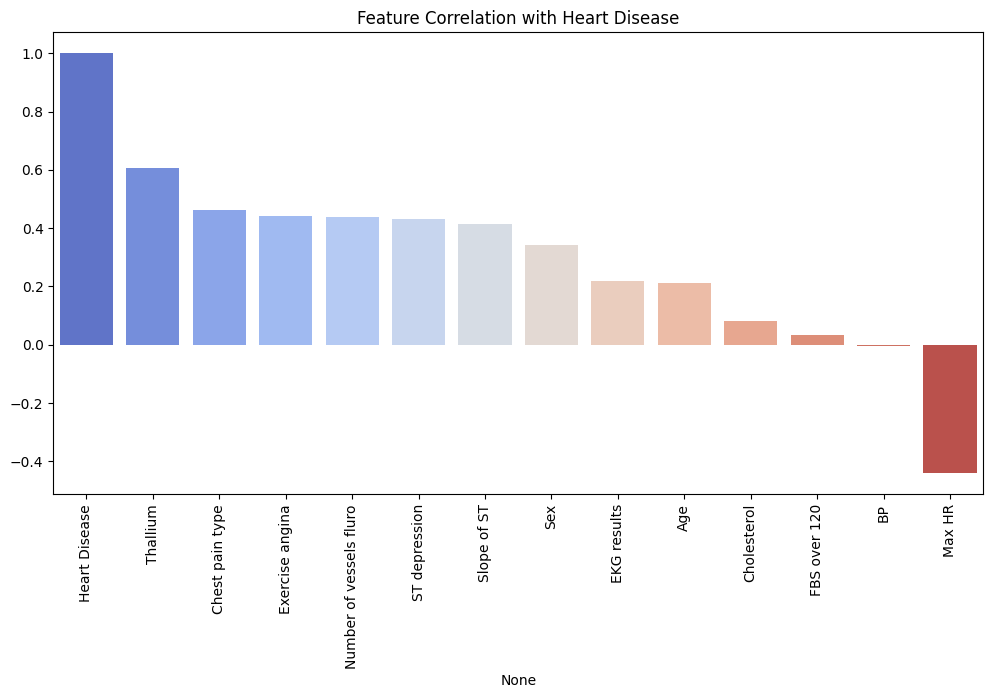


--- Distribution of Numerical Features ---


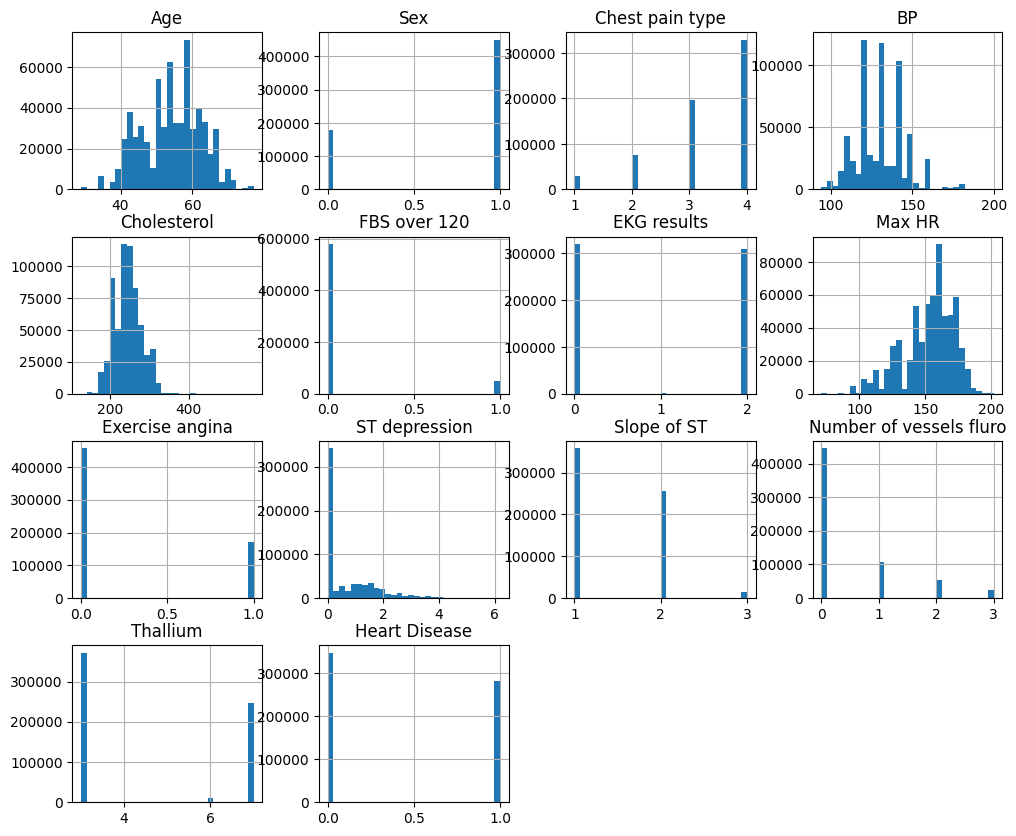


--- Box Plots for Outlier Detection ---


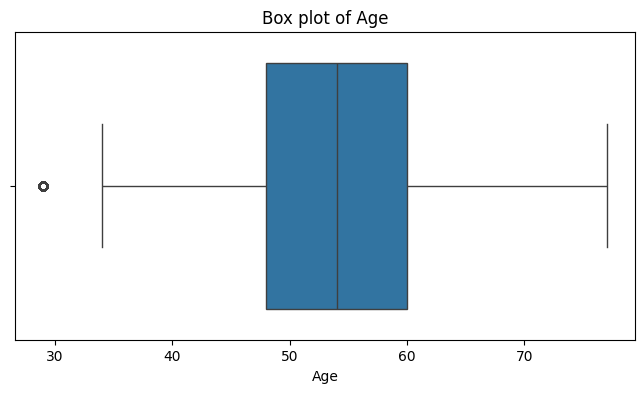

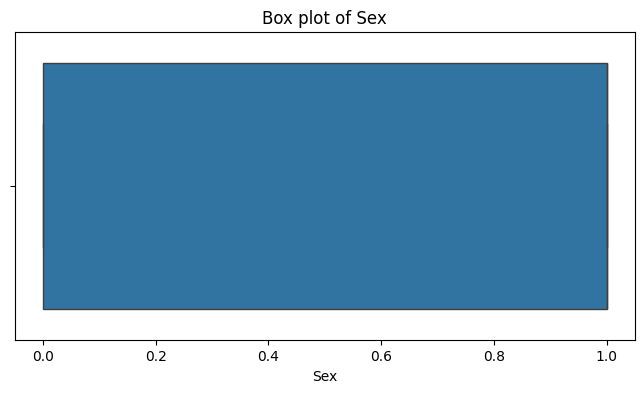

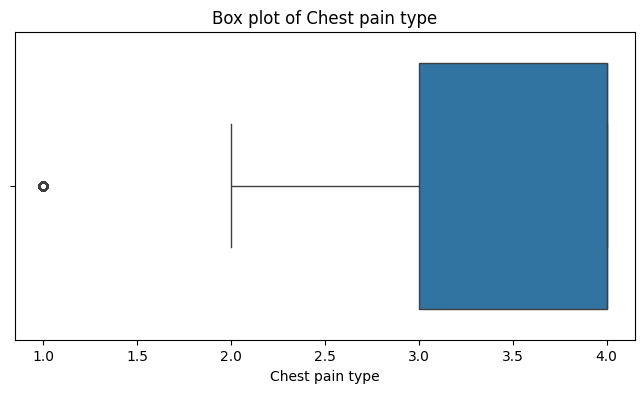

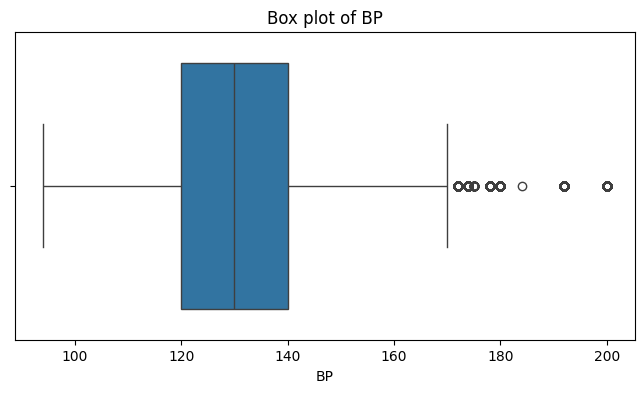

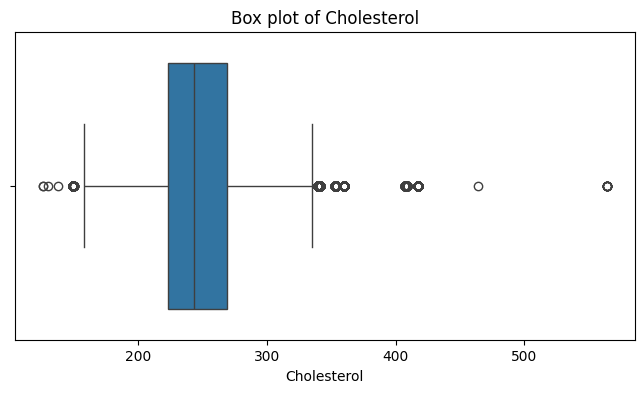

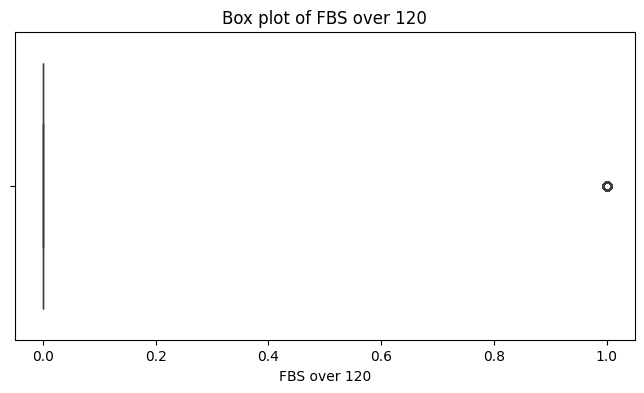

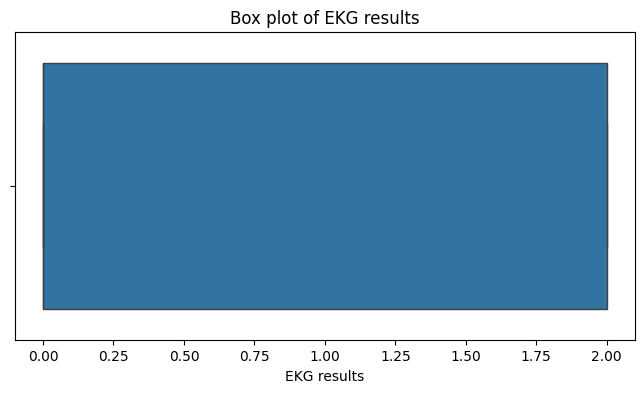

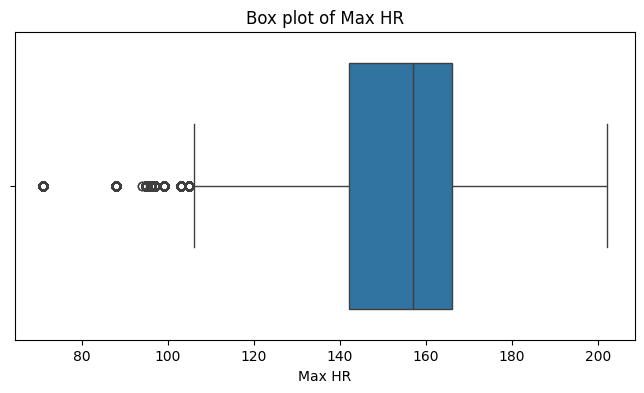

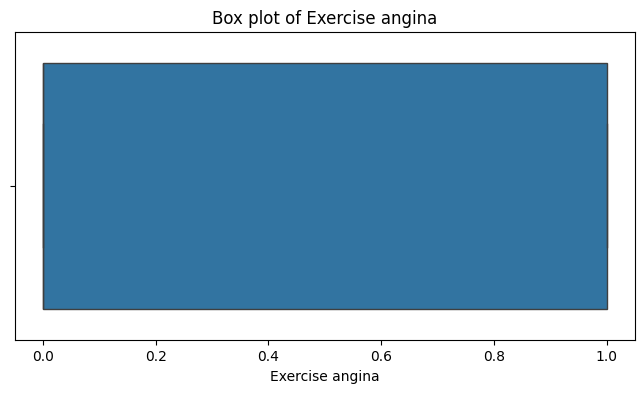

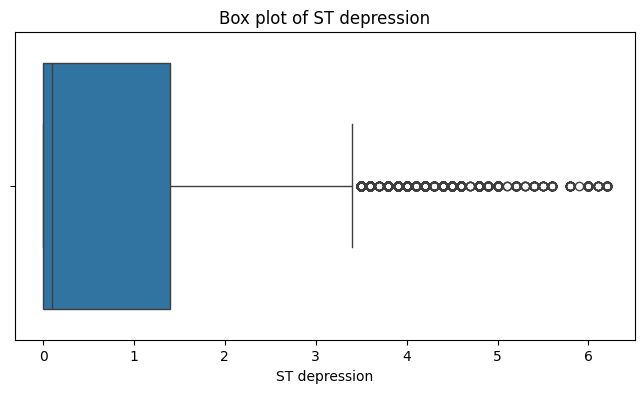

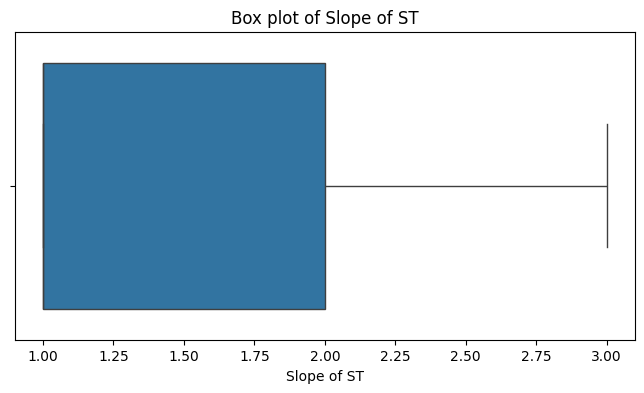

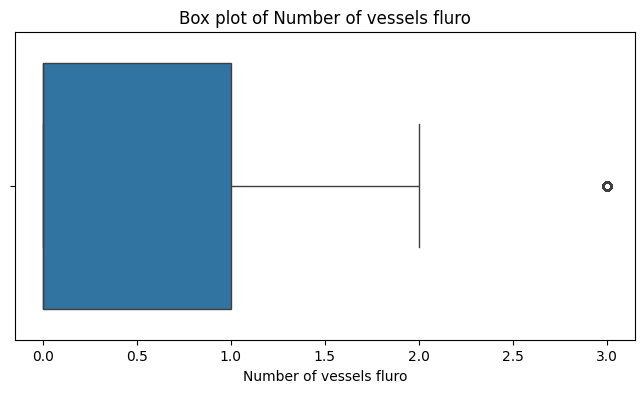

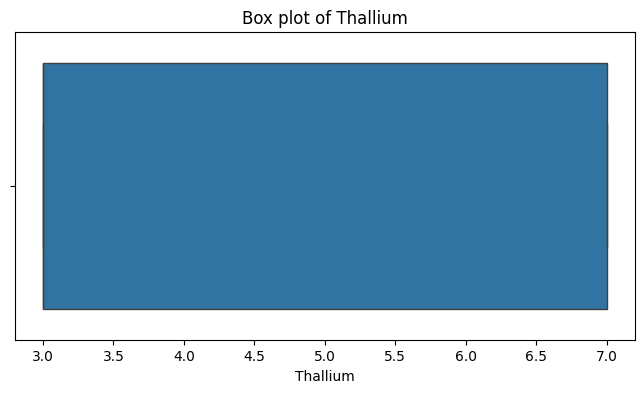

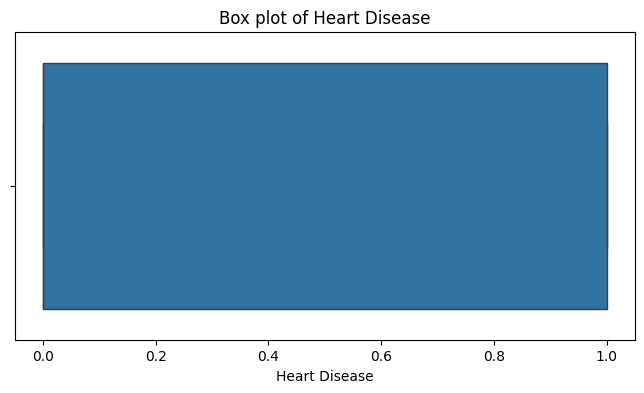


--- Value Counts for Categorical Columns ---


In [12]:
eda_pipeline(df_train, df_test)

# Important Observation
All features are currently numeric (int64 or float64). BUT several are actually categorical encoded as integers.These should NOT be treated as continuous:

Sex (0/1), Chest pain type (1–4), FBS over 120 (0/1), EKG results (0–2), Exercise angina (0/1), Slope of ST (1–3), Number of vessels fluro (0–3),Thallium (3,6,7 etc)

**If you treat them as continuous:**

→ Transformer will interpret them as ordinal relationships
→ This is incorrect inductive bias

We must explicitly define categorical columns.

This is:

✅ Binary classification

✅ No missing values

✅ No duplicates

✅ Mild imbalance (not severe)

✅ Large dataset (630k rows → ideal for transformer)

This is a perfect scenario for PyTabKit.

No need for:

1. SMOTE
2. Heavy class weighting
3. Focal loss
   
Standard BCE loss is fine.

In [13]:
df_train.shape,df_test.shape

((630000, 14), (270000, 13))

In [14]:
categorical_cols = [
    "Sex",
    "Chest pain type",
    "FBS over 120",
    "EKG results",
    "Exercise angina",
    "Slope of ST",
    "Number of vessels fluro",
    "Thallium"
]

numerical_cols = [
    "Age",
    "BP",
    "Cholesterol",
    "Max HR",
    "ST depression"
]

In [15]:
# Value counts for categorical features
print("\n--- Value Counts for Categorical Columns ---")
for col in df_train[categorical_cols]:
    print(f"\nValue counts for {col}:")
    print(df_train[col].value_counts())


--- Value Counts for Categorical Columns ---

Value counts for Sex:
Sex
1    450283
0    179717
Name: count, dtype: int64

Value counts for Chest pain type:
Chest pain type
4    329179
3    197278
2     74941
1     28602
Name: count, dtype: int64

Value counts for FBS over 120:
FBS over 120
0    579608
1     50392
Name: count, dtype: int64

Value counts for EKG results:
EKG results
0    320116
2    308562
1      1322
Name: count, dtype: int64

Value counts for Exercise angina:
Exercise angina
0    457553
1    172447
Name: count, dtype: int64

Value counts for Slope of ST:
Slope of ST
1    358293
2    256215
3     15492
Name: count, dtype: int64

Value counts for Number of vessels fluro:
Number of vessels fluro
0    445862
1    106978
2     54303
3     22857
Name: count, dtype: int64

Value counts for Thallium:
Thallium
3    372286
7    246748
6     10966
Name: count, dtype: int64


# Target Distribution


--- Distribution of Target Variable for Class Balance Check ---



<Axes: ylabel='Heart Disease'>

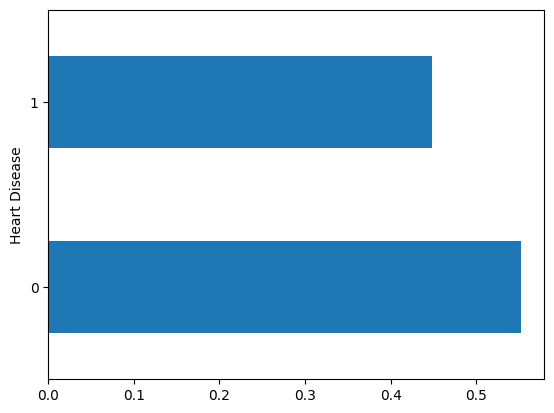

In [16]:
# Target Distribution Check
print("\n--- Distribution of Target Variable for Class Balance Check ---\n")
df_train[target_variable].value_counts(normalize=True).plot(kind='barh')

# SMOTE

**Synthetic Minority Over-sampling Technique**

is a common and effective way to deal with class imbalance, especially when your model is underperforming on the minority class.But keep in mind that we should only apply SMOTE to the training set, not validation/test sets otherwise it will introduce data leakage.   

But its not needed in our case as data set is not imblanced.


# Feature Engineering


Feature engineering is the process of transforming raw data into meaningful input variables (features) that improve a machine learning model’s performance.

**It involves:**

- Creating new features from existing ones
- Transforming variables (log, ratios, bins)
- Combining interacting variables
- Encoding categorical variables properly
- Removing noise or redundant information

In [17]:
# def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
#     df = df.copy()
    
#     # --- 1. Heart Rate Gap (Physiological max HR deviation)
#     df['hr_gap'] = df['Max HR'] - (220 - df['Age'])
    
#     # --- 2. ST × Exercise Angina interaction
#     df['st_angina'] = df['ST depression'] * df['Exercise angina']
    
#     # --- 3. Vessels × Thallium interaction
#     df['vessel_thal'] = df['Number of vessels fluro'] * df['Thallium']
    
#     # --- 4. Age / Max HR ratio
#     df['age_hr_ratio'] = df['Age'] / (df['Max HR'] + 1e-6)
    
#     # --- 5. Cholesterol / BP ratio
#     df['chol_bp_ratio'] = df['Cholesterol'] / (df['BP'] + 1e-6)
    
#     # --- 6. Log transform of ST depression
#     df['log_st'] = np.log1p(df['ST depression'])
    
#     return df

In [18]:
# df_train = add_engineered_features(df_train)
# df_test = add_engineered_features(df_test)

In [19]:
# df_train.shape,df_test.shape

# Data Preprocessing Pipeline

Preprocess the dataset by:

1. Filling missing values (mode for object columns, mean for numeric)
2. Label encoding categorical variables consistently in train and test

# LabelEncoder

In [20]:
# for col in categorical_cols:
#     df_train[col] = df_train[col].astype("category").cat.codes
#     df_test[col] = df_test[col].astype("category").cat.codes

# One-Hot Encoding

In [21]:
# 1. Apply One-Hot Encoding to both Train and Test
# 'drop_first=True' avoids multicollinearity (optional, but good for some models)
df_train = pd.get_dummies(df_train, columns=categorical_cols, dummy_na=False)
df_test  = pd.get_dummies(df_test,  columns=categorical_cols, dummy_na=False)

print("New Shape Train:", df_train.shape)
print("New Shape Test:", df_test.shape)

New Shape Train: (630000, 29)
New Shape Test: (270000, 28)


In [22]:
 df_train.head(2)

,Age,BP,Cholesterol,Max HR,ST depression,Heart Disease,Sex_0,Sex_1,Chest pain type_1,Chest pain type_2,Chest pain type_3,Chest pain type_4,FBS over 120_0,FBS over 120_1,EKG results_0,EKG results_1,EKG results_2,Exercise angina_0,Exercise angina_1,Slope of ST_1,Slope of ST_2,Slope of ST_3,Number of vessels fluro_0,Number of vessels fluro_1,Number of vessels fluro_2,Number of vessels fluro_3,Thallium_3,Thallium_6,Thallium_7
0,58,152,239,158,3.6,1,False,True,False,False,False,True,True,False,True,False,False,False,True,False,True,False,False,False,True,False,False,False,True
1,52,125,325,171,0.0,0,False,True,True,False,False,False,True,False,False,False,True,True,False,True,False,False,True,False,False,False,True,False,False


In [23]:
df_test.head(2)

,Age,BP,Cholesterol,Max HR,ST depression,Sex_0,Sex_1,Chest pain type_1,Chest pain type_2,Chest pain type_3,Chest pain type_4,FBS over 120_0,FBS over 120_1,EKG results_0,EKG results_1,EKG results_2,Exercise angina_0,Exercise angina_1,Slope of ST_1,Slope of ST_2,Slope of ST_3,Number of vessels fluro_0,Number of vessels fluro_1,Number of vessels fluro_2,Number of vessels fluro_3,Thallium_3,Thallium_6,Thallium_7
0,58,120,288,145,0.8,False,True,False,False,True,False,True,False,False,False,True,False,True,False,True,False,False,False,False,True,True,False,False
1,55,120,209,172,0.0,True,False,False,True,False,False,True,False,True,False,False,True,False,True,False,False,True,False,False,False,True,False,False


**1. Use LabelEncoder for tree-based models like XGBoost, LightGBM, CatBoost**

**2. Use OneHotEncoder for linear models (e.g., logistic regression) or deep learning**

# Standardization of Numerical Features

In [24]:
from sklearn.preprocessing import StandardScaler

def standardize_data(df_train, df_test):
    """
    Standardize all numerical features using StandardScaler,
    ensuring both train and test have the same columns, while preserving the target variable.
    """
    # Separate target column from train data
    target_values = df_train[target_variable]
    df_train = df_train.drop(columns=[target_variable])
    
    # Ensure both datasets have the same feature columns
    common_columns = df_train.columns.intersection(df_test.columns)
    df_train = df_train[common_columns]
    df_test = df_test[common_columns]
    
    # Initialize StandardScaler
    scaler = StandardScaler()
    
    # Fit on train data and transform both train and test data
    df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=common_columns)
    df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=common_columns)
    
    # Reattach the target column to the scaled train data
    df_train_scaled[target_variable] = target_values.reset_index(drop=True)
    
    return df_train_scaled, df_test_scaled

In [25]:
# df_train_scaled, df_test_scaled = standardize_data(df_train, df_test)

# Feature-Target Separation

In [26]:
X = df_train.drop(columns=[target_variable])
y = df_train[target_variable]

In [27]:
y.head(2)

0    1
1    0
Name: Heart Disease, dtype: int64

In [28]:
X.head(2)

,Age,BP,Cholesterol,Max HR,ST depression,Sex_0,Sex_1,Chest pain type_1,Chest pain type_2,Chest pain type_3,Chest pain type_4,FBS over 120_0,FBS over 120_1,EKG results_0,EKG results_1,EKG results_2,Exercise angina_0,Exercise angina_1,Slope of ST_1,Slope of ST_2,Slope of ST_3,Number of vessels fluro_0,Number of vessels fluro_1,Number of vessels fluro_2,Number of vessels fluro_3,Thallium_3,Thallium_6,Thallium_7
0,58,152,239,158,3.6,False,True,False,False,False,True,True,False,True,False,False,False,True,False,True,False,False,False,True,False,False,False,True
1,52,125,325,171,0.0,False,True,True,False,False,False,True,False,False,False,True,True,False,True,False,False,True,False,False,False,True,False,False


# Train-Test Splitting

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, 
                                                    random_state=42)

In [30]:
import pytabkit
# This will print a list of all available models/functions in the library
print([x for x in dir(pytabkit) if "Classifier" in x])

['CatBoost_D_Classifier', 'CatBoost_HPO_Classifier', 'CatBoost_HPO_TPE_Classifier', 'CatBoost_TD_Classifier', 'Ensemble_HPO_Classifier', 'Ensemble_TD_Classifier', 'FTT_D_Classifier', 'FTT_HPO_Classifier', 'LGBM_D_Classifier', 'LGBM_HPO_Classifier', 'LGBM_HPO_TPE_Classifier', 'LGBM_TD_Classifier', 'MLP_PLR_D_Classifier', 'MLP_PLR_HPO_Classifier', 'MLP_RTDL_D_Classifier', 'MLP_RTDL_HPO_Classifier', 'MLP_SKL_D_Classifier', 'RF_HPO_Classifier', 'RF_SKL_D_Classifier', 'RealMLP_HPO_Classifier', 'RealMLP_TD_Classifier', 'RealMLP_TD_S_Classifier', 'RealTabR_D_Classifier', 'Resnet_RTDL_D_Classifier', 'Resnet_RTDL_HPO_Classifier', 'TabM_D_Classifier', 'TabM_HPO_Classifier', 'TabR_HPO_Classifier', 'TabR_S_D_Classifier', 'XGB_D_Classifier', 'XGB_HPO_Classifier', 'XGB_HPO_TPE_Classifier', 'XGB_PBB_D_Classifier', 'XGB_TD_Classifier']


# RealMLP (Realistic MLP)

**Definition:**
RealMLP is a modernized Multilayer Perceptron introduced in the NeurIPS 2024 paper *"Better by Default"*. It is designed to bridge the gap between Deep Learning and Gradient Boosted Trees (XGBoost/CatBoost) on tabular data.

**Key Architectural Features:**
1.  **Robust Preprocessing:** Automatically applies Quantile Scaling and Smooth Clipping to handle the extreme outliers common in real-world tables.
2.  **Optimized Activations:** Uses smooth activation functions (Mish/SELU) to prevent dead neurons.
3.  **Tuned Defaults (TD):** Uses a set of hyperparameters (Learning Rate, Dropout, Weight Decay) that were meta-learned on 118 datasets to maximize generalization without manual tuning.

**Why we use it:**
It provides the non-linear feature learning capabilities of a Neural Network while matching the reliability and ease-of-use of Random Forests.

In [31]:
import torch
from pytabkit import RealMLP_TD_Classifier,RealMLP_HPO_Classifier,CatBoost_TD_Classifier, CatBoost_HPO_TPE_Classifier
from sklearn.metrics import f1_score,roc_auc_score

In [32]:
# Define RealMLP using the Classifier Wrapper
print("Training RealMLP TD...")

model_rmlp = RealMLP_TD_Classifier(
    device='cuda' if torch.cuda.is_available() else 'cpu',
    n_epochs=100,           # Lower than default (usually 100-256) for speed
    batch_size=4096,
    random_state=42,
    verbosity=-1            # Prints training progress
)

#  Fit (The wrapper handles the training loop internally)
# Pass cat_col_names so it knows how to handle categorical features
model_rmlp.fit(X_train, y_train, X_test, y_test)

#  Predict
val_pred_rmlp = model_rmlp.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, val_pred_rmlp)
print("RealMLP Validation ROC-AUC:", auc)

Training RealMLP TD...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RealMLP Validation ROC-AUC: 0.9545414866420825


# RealMLP HPO (Hyperparameter Optimization)

**RealMLP_HPO_Classifier** actively searches for the best architecture for your data.

**It tunes:**

    1. Hidden Layers: Should the network be wide (many neurons) or deep (many layers)?

    2. Dropout: How much regularization is needed to prevent overfitting?

    3. Learning Rate: How fast should the model learn?

Why use it? While Tree models (like XGBoost) are robust, Neural Networks often need HPO to shine. A "tuned" RealMLP often captures complex patterns that Trees miss entirely.

Performance Tip: Because Neural Networks are computationally expensive, start with n_hyperopt_steps=10 or 15. Even a small search can significantly outperform the defaults.

In [33]:
# print("Training RealMLP with HPO (Hyperparameter Optimization)...")

# model_rmlp_hpo = RealMLP_HPO_Classifier(
#     device='cuda' if torch.cuda.is_available() else 'cpu',
#     random_state=42,
#     n_epochs=100,           # Lower than default (usually 100-256) for speed
#     n_hyperopt_steps=5,     # <--- Tries 15 different Neural Network architectures
#     verbosity=-1             # Keep it quiet
# )

# model_rmlp_hpo.fit(X_train, y_train, X_test, y_test)

# # Predict
# val_pred_rmlp_hpo = model_rmlp_hpo.predict_proba(X_test)[:, 1]

# print(f"RealMLP HPO Validation ROC-AUC: {roc_auc_score(y_test, val_pred_rmlp_hpo):.5f}")

# CatBoost Tuned Defaults (TD)

CatBoost_TD_Classifier is the standard entry point for PyTabKit. It uses a static set of "best practice" hyperparameters derived from benchmarking on dozens of tabular datasets.

**How it works**
Instead of running a search, it instantly loads a configuration known to work well on average (e.g., specific tree depth, learning rate, and bagging temperature). It prioritizes robustness over absolute peak performance to prevent overfitting on the first run.

Pros & Cons
1. Instant Start: No "search time" required; training starts immediately.

2. Stable Baseline: Great for establishing a score to beat (e.g., your 0.888 ROC-AUC).

3. Static: It does not adapt to the specific quirks of your dataset (e.g., if your data needs unusually deep trees, TD might underperform).

In [34]:
print("Training CatBoost (TD)...")

model_cat = CatBoost_TD_Classifier(
    device='cuda' if torch.cuda.is_available() else 'cpu',
    random_state=42,
    n_cv=5,
    verbosity=-1
)

model_cat.fit(X_train, y_train, X_test, y_test)

val_pred_cat = model_cat.predict_proba(X_test)[:,1]
print(f"CatBoost TD Validation ROC-AUC: {roc_auc_score(y_test, val_pred_cat):.5f}")

Training CatBoost (TD)...
CatBoost TD Validation ROC-AUC: 0.95616


# CatBoost HPO (Hyperparameter Optimization)

**CatBoost_HPO_Classifier** and its sibling **CatBoost_HPO_TPE_Classifier** are the "Power User" version. Instead of using static settings, it runs a search algorithm to find the perfect configuration for your specific dataset.

**The Two Flavors**
**HPO (Random Search):**  Randomly tries different combinations of parameters. Simple but inefficient.

**HPO_TPE (Tree-Structured Parzen Estimator):** Uses Bayesian optimization to "learn" from previous trials. If depth=4 was bad and depth=10 was good, it is smart enough to try depth=9 next.

**Pros & Cons**
1.  Higher Peak Score: Almost always beats the TD version given enough time.

2.  Adaptive: Automatically discovers if your data prefers high regularization or deep trees.

3. Slow: Requires a time_limit_s (time budget). You must wait for the search to finish before the final model trains.

In [35]:
print("Running Smart Hyperparameter Optimization (TPE)...")

model_tpe = CatBoost_HPO_TPE_Classifier(
    device='cuda' if torch.cuda.is_available() else 'cpu',
    random_state=42,
    n_cv=5,
    n_hyperopt_steps=20,
    verbosity=-1
)

model_tpe.fit(X_train, y_train,X_test, y_test)    

val_pred_tpe = model_tpe.predict_proba(X_test)[:, 1]
print(f"CatBoost TPE Validation ROC-AUC: {roc_auc_score(y_test, val_pred_tpe):.5f}")

Running Smart Hyperparameter Optimization (TPE)...
Hyperopt step 1/20 on split 0 of CatBoost_HPO_TPE_Classifier took 35.6183 s
Hyperopt step 2/20 on split 0 of CatBoost_HPO_TPE_Classifier took 57.8706 s
Hyperopt step 3/20 on split 0 of CatBoost_HPO_TPE_Classifier took 53.9818 s
Hyperopt step 4/20 on split 0 of CatBoost_HPO_TPE_Classifier took 456.23 s
Hyperopt step 5/20 on split 0 of CatBoost_HPO_TPE_Classifier took 25.7337 s
Hyperopt step 6/20 on split 0 of CatBoost_HPO_TPE_Classifier took 47.4295 s
Hyperopt step 7/20 on split 0 of CatBoost_HPO_TPE_Classifier took 62.4884 s
Hyperopt step 8/20 on split 0 of CatBoost_HPO_TPE_Classifier took 41.2206 s
Hyperopt step 9/20 on split 0 of CatBoost_HPO_TPE_Classifier took 32.0573 s
Hyperopt step 10/20 on split 0 of CatBoost_HPO_TPE_Classifier took 62.571 s
Hyperopt step 11/20 on split 0 of CatBoost_HPO_TPE_Classifier took 28.9705 s
Hyperopt step 12/20 on split 0 of CatBoost_HPO_TPE_Classifier took 42.9685 s
Hyperopt step 13/20 on split 0 of Ca

# Final prediction

In [36]:
final_prediction=model_tpe.predict_proba(df_test)

In [37]:
final_prediction

array([[0.04924063, 0.9507594 ],
       [0.9932173 , 0.00678272],
       [0.01189105, 0.98810893],
       ...,
       [0.9568006 , 0.04319944],
       [0.8178586 , 0.18214141],
       [0.97266066, 0.02733933]], dtype=float32)

In [38]:
sample_submission['Heart Disease'] = final_prediction[:,1]
sample_submission.to_csv('submission.csv', index=False)
print('Submission file saved.')

Submission file saved.


In [39]:
sample_submission.head(5)

,id,Heart Disease
0,630000,0.950759
1,630001,0.006783
2,630002,0.988109
3,630003,0.003314
4,630004,0.196626
